## Import needed libraries
- numpy
- pandas
- matplotlib
- seaborn
- sklearn
- scipy stats

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

### Read the data

In [3]:
train = pd.read_csv('../data/train.csv')
test =  pd.read_csv('../data/test.csv')
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print(all_data.shape)

(2919, 79)


## Preprocessing the data
#### Step 1: Take tranformations of skewed numeric features
#### Step 2: FInding dummy variables for categorical features
#### Step 3: Replacing nan/null values

Before starting the preprocessing, we need to take the log tranformation of the target which Sales Price. This can be done by taking into account non-linearity or errors dues to linear fitting(normalize the errors). For more information about the transformations please check [here](https://people.duke.edu/~rnau/regex3.htm). 

In [4]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#### Let's see the difference 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0e4d45390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe0e29bbd50>]], dtype=object)

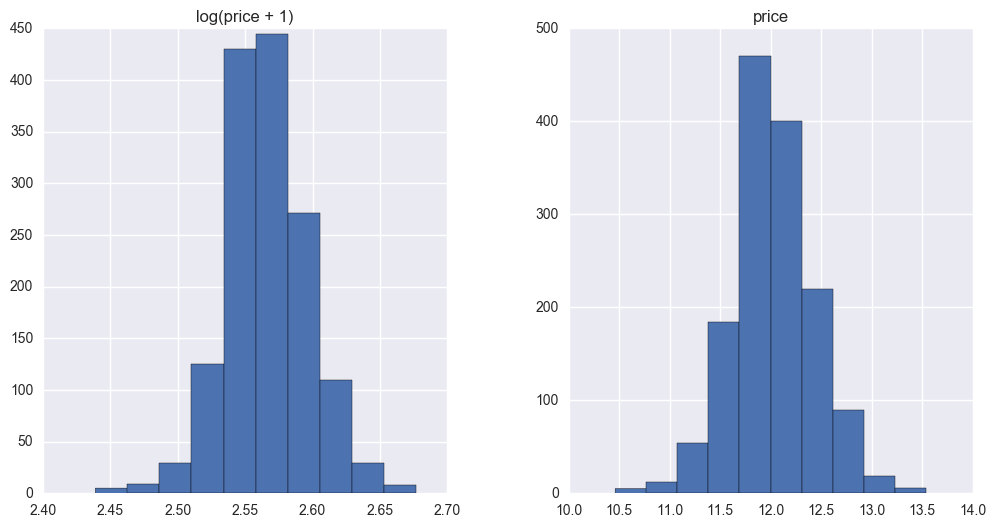

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

### Step 1: Transformations
As explained also above, In this way we will get more normal features 

In [6]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

### Step 2: Getting dummy variables
Why to use dummy variables in regression models? please check [here](http://www.psychstat.missouristate.edu/multibook/mlt08m.html)

In [7]:
all_data = pd.get_dummies(all_data)

### Step 3: Imputation of Missing Values
Missing values in each column are filled by the mean of the column.

In [8]:
all_data = all_data.fillna(all_data.mean())


### Optional Steps
#### *Step 4: Removing columns which have moslty zero values (insignificant features can be removed)*
#### *Step 5: Apply outlier analysis for training part*
#### *Step 6: One can also cretae his/her own features to add the data*

### Finalize the data for building the model

In [9]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

#### Optional: to save new data 
Save the currently created matrices for later usage

In [22]:
# new_test = pd.DataFrame(X_test.copy())
# new_test['Id'] = test['Id'].copy()
# new_test.to_csv("../data/new_test.csv", index=False)

# new_train = pd.DataFrame(X_train.copy())
# new_train['SalePrice'] = y.copy()
# new_train.to_csv("../data/new_train.csv", index=False)

## Build Models 
#### * Model 1 : Multiple Regression (Linear Regression)*
#### * Model 2: Bayesian Ridge Regression*

### Model 1 - Linear Regression

In [10]:
# Create linear regression object
linear_regr = LinearRegression()
# apply-cross validation
# linear_reg_scores = cross_val_score(linear_regr, X_train, y, cv=5)

# Train the model using the training sets
linear_regr.fit(X_train, y)
# make predictions on the test set
y_linear_regr_pred = linear_regr.predict(X_test)

In [11]:
#save the file
lr_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_linear_regr_pred})
lr_sol.to_csv("../data/linreg_sol.csv", index = False)

### Model 2: Bayesian Ridge Regression

In [12]:
# Create bayesian regression object
bayes_reg = BayesianRidge(compute_score=True)
# train the model
bayes_reg.fit(X_train, y)
# make predictions on the test set
y_bayes_regr_pred = bayes_reg.predict(X_test)

In [13]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_bayes_regr_pred})
br_sol.to_csv("../data/bayesreg_sol.csv", index = False)

### Model 3: Support Vector Regression - non-linear kernels

In [14]:
# Create SVR object
svr_lin =  SVR(kernel='rbf', C=1e3, gamma=0.1)
# train the model
svr_lin.fit(X_train, y)
# make predictions on the test set
y_svr_regr_pred = svr_lin.predict(X_test)

In [15]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_svr_regr_pred})
br_sol.to_csv("../data/svrreg_sol.csv", index = False)

### Model 4: Random Forest Regression

In [16]:
# Create Random Forest regressor object with default settings
rf_regr = RandomForestRegressor()
# train the model
rf_regr.fit(X_train, y)
# make predictions on the test set
y_rf_regr_pred = rf_regr.predict(X_test)

In [17]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_rf_regr_pred})
br_sol.to_csv("../data/rfreg_sol.csv", index = False)

### Model 5: KNN Regression

In [18]:
# Create KNN regression object
knn_regr = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
# train the model
knn_regr.fit(X_train, y)
# make predictions on the test set
y_knn_regr_pred = knn_regr.predict(X_test)

In [19]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_knn_regr_pred})
br_sol.to_csv("../data/knnreg_sol.csv", index = False)

### Model 6: Multilayer perceptron Regression

In [24]:
# # Create MLP regression object
mlp_reg = MLPRegressor(hidden_layer_sizes=(20,30,20,20,20), activation='relu', solver='adam',
                        alpha=0.0001, batch_size='auto')
# # train the model
mlp_reg.fit(X_train, y)
# # make predictions on the test set
y_mlp_regr_pred = mlp_reg.predict(X_test)

In [26]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_mlp_regr_pred})
br_sol.to_csv("../data/mlpreg_sol.csv", index = False)

In [25]:
mlp_reg.score(X_train,y)

0.44303334121348703

## One-way ANOVA Analysis

Here we are going to implement anova analysis for the obtained results from different classifiers

In [27]:
matplotlib.use('agg')

/home/sinan/anaconda2/envs/gl-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [28]:
## combine these different collections into a list    
data_to_plot = [y_linear_regr_pred, y_bayes_regr_pred,y_knn_regr_pred,
                y_mlp_regr_pred,y_rf_regr_pred,y_svr_regr_pred]

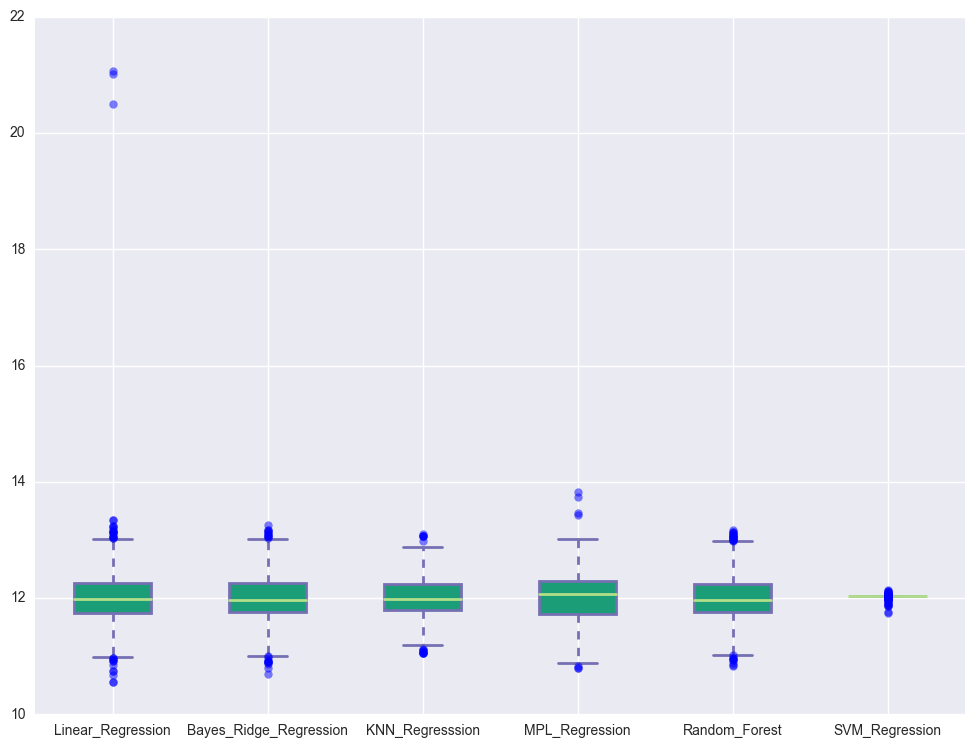

In [29]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))

# Create an axes instance
ax = fig.add_subplot(111)


## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)
## Custom x-axis labels
ax.set_xticklabels(['Linear_Regression', 'Bayes_Ridge_Regression', 'KNN_Regresssion', 
                    'MPL_Regression','Random_Forest','SVM_Regression'])
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

In [30]:
# Save the figure
fig.savefig('../data/fig1.png', bbox_inches='tight')

In [31]:
from pyvttbl import DataFrame

In [58]:
data1 = pd.DataFrame({"Regression":y_linear_regr_pred,"Group":"Bayes"})
data2 = pd.DataFrame({"Regression":y_bayes_regr_pred,"Group":"linear"})
frames = [data1,data2]
result = pd.concat(frames)
pf = DataFrame(result)
# pf.insert(knn_regr)
aov_pyvttbl = pf.anova1way("Regression", "Group")
# # print aov_pyvttbl
# help(pf.anova)
print(aov_pyvttbl)


Anova: Single Factor on Regression

SUMMARY
Groups   Count      Sum      Average   Variance 
Bayes     1459   17547.902    12.027      0.326 
linear    1459   17522.854    12.010      0.157 

O'BRIEN TEST FOR HOMOGENEITY OF VARIANCE
Source of Variation      SS        df      MS       F     P-value   eta^2   Obs. power 
Treatments               20.624      1   20.624   3.266     0.071   0.001        0.439 
Error                 18415.014   2916    6.315                                        
Total                 18435.638   2917                                                 

ANOVA
Source of Variation     SS       df     MS       F     P-value     eta^2     Obs. power 
Treatments              0.215      1   0.215   0.890     0.346   3.052e-04        0.157 
Error                 704.318   2916   0.242                                            
Total                 704.533   2917                                                    

POSTHOC MULTIPLE COMPARISONS

Tukey HSD: Table of q